# Formation energy prediction task 01

Подготовим прогноз энергии образования с помощью модели GNN. 

Let's prepare a prediction of the formation energy using the GNN model.

## Import libraries Импорт библиотек

In [ ]:
# common libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm, os
import seaborn as sns
from datetime import date

from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

# torch libraries
import torch
from torch.utils.data import DataLoader

# Torch geometric libraries
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader as DataLoader_geometric

# import modules
from models.GNN_first import GCN

# assistive libraries
plt.rcParams.update(plt.rcParamsDefault) # Сброс настроек
import openpyxl # работа с excel

## Loading dataset Загружаем данные

In [7]:
# загружаем датафрейм df_Fm-3m.xlsx
PATH_FOR_LOAD = r'.\data\datafraims\df_Fm-3m.xlsx'
df_load = pd.read_excel(PATH_FOR_LOAD)

In [8]:
# смотрим
df_load.tail(2)

,composition,structure,formation_energy_per_atom
1255,Zr1 Sn3,Full Formula (Zr1 Sn3)\nReduced Formula: ZrSn3...,0.115889
1256,Zr1 Zn1,Full Formula (Zr1 Zn1)\nReduced Formula: ZrZn\...,0.104294


In [9]:
# создадим класс для загрузки графов из соответствующей папки репозитория  
class ProcessedDataset_new_dir(Dataset): # (наследник torch_geometric.data.Dataset)
    '''пользовательский класс ProcessedDataset для работы с предобработанными графами кристаллических структур, 
    сохраненными в файлах .pt, и выводит статистику о данных.'''

    # Инициализирует датасет:
    # root: Путь к папке с данными, transform/pre_transform/pre_filter: Опциональные функции для преобразования данных (не используются здесь).
    def __init__(self, root, new_dir_for_load_grahs, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.processed_new_dir = new_dir_for_load_grahs

    @property
    def processed_dir(self):
        return os.path.join(self.root, self.processed_new_dir)  # Кастомный путь
    
    # Возвращает список файлов .pt в папке processed
    @property
    def processed_file_names(self):
        file_names = []
        for i in os.listdir(self.processed_dir):
            if '.pt' in i:
                file_names.append(i)
        return file_names
    

    # Возвращает количество графов в датасете:
    def len(self):
        return len(self.processed_file_names)

    # Загружает граф по индексу idx
    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [10]:
# загружаем датасет
dataset = ProcessedDataset_new_dir('./', './data/graphs_structures_Fm_3m')

In [58]:
# смотрим данные о датасете
print()
print(f'Dataset: {dataset}:')
print('=' * 79)
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Dataset: ProcessedDataset_new_dir(1257):
Number of graphs: 1257
Number of features: 5


In [60]:
data_example = dataset[0]  # Get the first graph object.
# data = dataset_new_dir[0]  # Get the first graph object.

print()
print('data_example', data_example)
print('=' * 79)

# Gather some statistics about the first graph.
print(f'Number of nodes: {data_example.num_nodes}')
print(f'Number of node features: {data_example.num_node_features}')
print(f'Number of edges: {data_example.num_edges}')
print(f'Number of edge feats: {data_example.num_edge_features}')


data_example Data(x=[32, 5], y=[1, 1], pos=[32, 3], lattice=[1, 9], edge_index=[2, 192])
Number of nodes: 32
Number of node features: 5
Number of edges: 192
Number of edge feats: 0


In [61]:
data_example.x

tensor([[89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [89.0000, 22.5500,  0.3500,  3.0000,  3.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 9.0000, 11.2000,  3.4012, -1.0000, -1.0000],
        [ 

In [56]:
# смотрим тип и как читается ссылка
type(dataset), dataset.processed_new_dir

(__main__.ProcessedDataset_new_dir, './data/graphs_structures_Fm_3m')

In [12]:
# смотрим данные о датасете
print()
print(f'Dataset: {dataset}:')
print('=' * 79)
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Dataset: ProcessedDataset_new_dir(1257):
Number of graphs: 1257
Number of features: 5


## Splitting the data into train and test  Разбивка данных на обучающие и тестовые

Для первого варианта возьмём размер обучающей выборки 85%

In [13]:
# 85% of data will be presented in the training set
train_fraction = 0.85

train_set_size = round(df_load.shape[0] * train_fraction)
print('Number of samples in the training set:', train_set_size)


# Get indexes for train and test # Получаем индексы обучающей и тестовой выборки

# Define train indices to compare differen models
train_idxs = df_load.sample(train_set_size).index

# Inverse selection of samples that are not in the train indices
test_idxs = df_load.loc[df_load.index.difference(train_idxs)].index

Number of samples in the training set: 1068


In [ ]:
# получаем обучающий и тестовый датасеты
train_dataset = dataset[list(train_idxs)]
test_dataset = dataset[list(df_load.index.difference(train_idxs))]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1068
Number of test graphs: 189


## Breakdown of data by batches Разбивка данных по пакетам

In [15]:
# разбивка по пакетам
train_loader = DataLoader_geometric(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader_geometric(test_dataset, batch_size=228, shuffle=False)

# смотрим как разбились данные в train_loader
# we are looking at how the data is distributed in train_loader
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[8840, 5], y=[256, 1], pos=[8840, 3], lattice=[256, 9], edge_index=[2, 53040], batch=[8840], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[11288, 5], y=[256, 1], pos=[11288, 3], lattice=[256, 9], edge_index=[2, 67728], batch=[11288], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[8776, 5], y=[256, 1], pos=[8776, 3], lattice=[256, 9], edge_index=[2, 52656], batch=[8776], ptr=[257])

Step 4:
Number of graphs in the current batch: 256
DataBatch(x=[9008, 5], y=[256, 1], pos=[9008, 3], lattice=[256, 9], edge_index=[2, 54048], batch=[9008], ptr=[257])

Step 5:
Number of graphs in the current batch: 44
DataBatch(x=[1304, 5], y=[44, 1], pos=[1304, 3], lattice=[44, 9], edge_index=[2, 7824], batch=[1304], ptr=[45])



In [16]:
# смотрим как разбились данные в test_loader
# we are looking at how the data is distributed in test_loader
for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 189
DataBatch(x=[8560, 5], y=[189, 1], pos=[8560, 3], lattice=[189, 9], edge_index=[2, 51360], batch=[8560], ptr=[190])



## Initiating the model / Инициируем модель

In [17]:
dataset.num_node_features

5

In [ ]:
# # import modules
# from models.GNN_first import GCN

In [18]:
# defining hyperparameters / определяем гиперпараметры 
hyperparameters = {'hidden_embeding':128, 'num_node_features': dataset.num_node_features}

# инициируем модель 
model = GCN(hyperparameters=hyperparameters,)

## Optimizer and loss function / Оптимизатор и функция потерь

In [19]:
# создание оптимизатора Adam для обучения нейронной сети. Оптимизатор отвечает за обновление весов модели в процессе обучения.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# добавил самостоятельно, насколько это тут необходимо пока не совсем понимаю
criterion = torch.nn.MSELoss()

## Model launch function / Функция запуска модели

In [ ]:
def run_model(model, epochs, train_loader, test_loader):
    """
    Основная функция для обучения и оценки модели.
    
    Параметры:
        model (torch.nn.Module): Нейронная сеть для обучения
        epochs (int): Количество эпох обучения
        train_loader (torch_geometric.loader.DataLoader): Загрузчик тренировочных данных
        test_loader (torch_geometric.loader.DataLoader): Загрузчик тестовых данных
    """
    
    def train():
        """
        Внутренняя функция для одной эпохи обучения.
        Возвращает суммарный лосс за эпоху.
        """
        # Переводим модель в режим обучения (важно для слоёв типа Dropout, BatchNorm)
        model.train()
        val_loss = 0  # Инициализируем переменную для накопления лосса

        # Итерируемся по батчам тренировочных данных
        for data in train_loader:
            # 1. Прямой проход (forward pass) - вычисление предсказаний модели
            out = model(data)

            # 2. Вычисление функции потерь между предсказаниями и истинными значениями
            loss = criterion(out, data['y'])

            # 3. Обратное распространение ошибки (backward pass) - вычисление градиентов
            loss.backward()

            # 4. Обновление параметров модели на основе вычисленных градиентов
            optimizer.step()

            # 5. Обнуление градиентов перед следующим батчем
            optimizer.zero_grad()

            # 6. Накопление лосса (detach() чтобы избежать накопления в вычислительном графе)
            val_loss += loss.detach().item()

        return val_loss  # Возвращаем суммарный лосс за эпоху


    def test(loader):
        """
        Внутренняя функция для оценки модели на переданном загрузчике данных.
        Возвращает среднее значение R2-score по всем батчам.
        """
        # Переводим модель в режим оценки (отключаем Dropout и т.д.)
        model.eval()
        r2 = []  # Список для хранения R2-score по каждому батчу

        # Итерируемся по батчам данных (без вычисления градиентов)
        for data in loader:
            # Получаем предсказания модели
            out = model(data)

            # Преобразуем предсказания и истинные значения в 1D массивы
            pred = out.detach().ravel()  # detach() чтобы не вычислять градиенты
            true = data['y'].ravel()

            # Вычисляем R2-score для текущего батча и сохраняем
            r2.append(r2_score(pred.numpy(), true.numpy()))

        # Возвращаем среднее значение R2-score по всем батчам
        return np.array(r2).mean()

    # Основной цикл обучения
    for epoch in range(1, epochs+1):
        # Одна эпоха обучения и получение лосса
        val_loss = train()
        
        # Вывод информации о текущей эпохе
        print(f'Epoch: {epoch:03d}, Val Loss: {val_loss:.4f}')

        # Каждые 10 эпох оцениваем модель на тренировочных и тестовых данных
        if epoch % 10 == 0:
            train_acc = test(train_loader)  # R2 на тренировочных данных
            test_acc = test(test_loader)   # R2 на тестовых данных
            print(f'Train R2: {train_acc:.4f}, Test R2: {test_acc:.4f}')

 ## Launching training and testing of the model / Запуск обучения и тестирования модели

In [22]:
run_model(model, 60, train_loader, test_loader)

Epoch: 001, Val Loss: 9.0767
Epoch: 002, Val Loss: 4.8976
Epoch: 003, Val Loss: 3.8651
Epoch: 004, Val Loss: 3.6876
Epoch: 005, Val Loss: 3.4006
Epoch: 006, Val Loss: 3.3936
Epoch: 007, Val Loss: 3.0683
Epoch: 008, Val Loss: 2.9757
Epoch: 009, Val Loss: 2.7816
Epoch: 010, Val Loss: 2.9917
Train R2: 0.0522, Test R2: -0.2242
Epoch: 011, Val Loss: 2.5828
Epoch: 012, Val Loss: 2.3908
Epoch: 013, Val Loss: 2.4830
Epoch: 014, Val Loss: 2.4114
Epoch: 015, Val Loss: 2.3365
Epoch: 016, Val Loss: 2.0433
Epoch: 017, Val Loss: 2.0576
Epoch: 018, Val Loss: 2.0388
Epoch: 019, Val Loss: 1.6927
Epoch: 020, Val Loss: 1.6809
Train R2: 0.6358, Test R2: 0.4890
Epoch: 021, Val Loss: 1.5998
Epoch: 022, Val Loss: 1.6761
Epoch: 023, Val Loss: 1.5382
Epoch: 024, Val Loss: 1.3445
Epoch: 025, Val Loss: 1.3050
Epoch: 026, Val Loss: 1.3087
Epoch: 027, Val Loss: 1.4991
Epoch: 028, Val Loss: 1.8006
Epoch: 029, Val Loss: 1.8291
Epoch: 030, Val Loss: 1.4745
Train R2: 0.7044, Test R2: 0.5506
Epoch: 031, Val Loss: 1.291

## Graph Model Evaluation / Оценка графической модели

In [24]:
model.eval()

test_loader = DataLoader_geometric(test_dataset, batch_size=1)

pred, true = [], []
for data in test_loader:
    out = model(data)
    pred.append(out.item())
    true.append(data.y.item())

len(pred), len(true)

(189, 189)

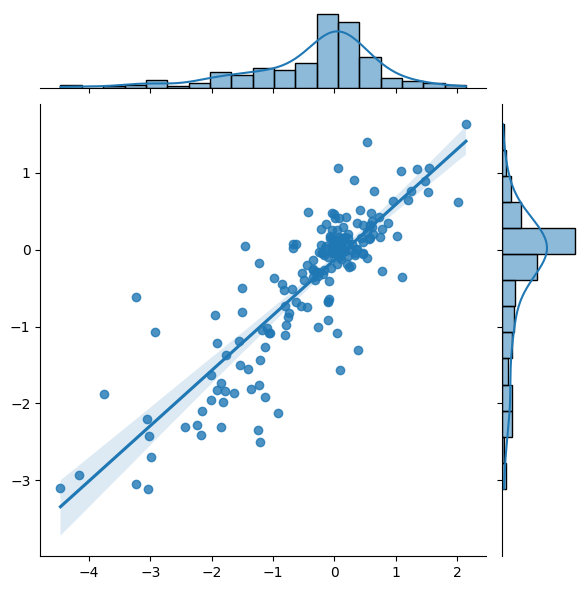

In [25]:
sns.jointplot(x=true, y =pred, kind='reg')
plt.show()

In [26]:
r2_score(pred, true), mean_absolute_error(pred, true)

(0.6184309666857655, 0.38390395455505877)

## Saving the result to a table / Сохраним результат в таблицу

В таблице сохраним дату и время, название модели, прогнозируемая величина, название папки с данными, информация о %train, показатель r2, показатель MAE, комментарии.

In [52]:
# созданим датафрейм
df_results = pd.DataFrame(columns=['Date', 'Model', 'Predicted_property', 'Name_data_folder', '%_train', 'Train_R2', 'Test_R2', 'Test_MAE', 'Comments'])

In [49]:
str(date.today())

'2025-04-02'

In [53]:
# добавляем данные в датафрейм
df_results.loc[len(df_results)] = \
    [str(date.today()),
     'from models.GNN_first import GCN',
     'Formation_energy (eV/atom)',
     'data/graphs_structures_Fm_3m',
     '15%',
     0.8216,
     0.6184,
     0.383903,
     'First predict in this project'
     ]

In [ ]:
# смотрим таблицу
df_results

,Date,Model,Predicted_property,Name_data_folder,%_train,Train_R2,Test_R2,Test_MAE,Comments
0,2025-04-02,from models.GNN_first import GCN,Formation_energy (eV/atom),data/graphs_structures_Fm_3m,15%,0.8216,0.6184,0.383903,First predict in this project


In [55]:
# записываем датафрейм
PATH_FOR_SAVE = './results/df_results.xlsx'
df_results.to_excel(PATH_FOR_SAVE, index=False)

## **Project results / Вывод по проекту: "Предсказание энергии образования кристаллов с помощью GNN"**  

### **Архитектура модели GNN для предсказания энергии образования кристаллов**

Применяемая модель представляет собой **графовую нейронную сеть (GNN)**, специально разработанную для анализа кристаллических структур и предсказания их энергии образования. Она сочетает обработку локальных атомных взаимодействий и глобальных параметров кристаллической решётки.  

---

#### **1. Входные данные**  
Модель принимает на вход **графы кристаллических структур**, где:  
- **Узлы** — атомы с их свойствами (атомный номер, молярный объём, электроотрицательность и др.).  
- **Рёбра** — химические связи между атомами, заданные через `edge_index`.  
- **Глобальные параметры** — тензор с параметрами кристаллической решётки (3×3 матрица в виде вектора из 9 элементов).  

---

#### **2. Основные компоненты архитектуры**

1. **Структурный эмбеддинг (PointTransformerConv)**  
   - Преобразует **атомные признаки** и их **геометрическое расположение** (координаты) в векторные представления.  
   - Учитывает связи между атомами (`edge_index`) и их пространственную близость (`pos`).  
   - Аналогичен механизму внимания (attention), но оптимизирован для материаловедческих задач.  

2. **Глобальное усреднение (Global Mean Pooling)**  
   - Агрегирует атомные эмбеддинги в **единый вектор** для всей кристаллической структуры.  
   - Позволяет модели работать с кристаллами разного размера.  

3. **Эмбеддинг решётки (Linear)**  
   - Кодирует **параметры кристаллической решётки** (периодичность ячейки) в скрытое пространство той же размерности, что и структурные признаки.  

4. **Объединение признаков**  
   - Вектор структурных признаков (после pooling) и вектор решётки объединяются в **один дескриптор кристалла**.  

5. **Полносвязные слои (MLP)**  
   - Каскад линейных слоёв с активацией ReLU:  
     - Уменьшает размерность объединённого вектора.  
     - Выявляет нелинейные зависимости между структурой и энергией.  

6. **Выходной слой (Linear)**  
   - Фиксирует результат в виде **скалярного значения** — предсказанной энергии образования.  

---

#### **3. Особенности архитектуры**  
- **Гибкость**: Может обрабатывать кристаллы с произвольным числом атомов благодаря механизму pooling.  
- **Учёт геометрии**: PointTransformerConv явно использует координаты атомов, что критично для материаловедения.  
- **Комбинация признаков**: Совмещает **локальные** (атомные) и **глобальные** (решёточные) свойства.  

---

#### **4. Ограничения и возможные улучшения**  
- **Нет учёта углов** между связями (можно добавить SchNet или DimeNet++).  
- **Отсутствие регуляризации** (например, Dropout) — может привести к переобучению на малых датасетах.  
- **Зависимость от качества графов**: Точность предсказаний сильно зависит от способа построения графа (например, выбора радиуса обрезания связей).  

---

#### **5. Практическое применение**  
Модель подходит для:  
- Быстрого скрининга стабильных кристаллических структур.  
- Предсказания свойств материалов без дорогостоящих квантово-химических расчётов.  
- Сравнительного анализа разных классов соединений (например, сплавов с одинаковой пространственной группой).  

Эта архитектура — **базовый, но эффективный инструмент** для задач материаловедения, который можно дорабатывать под конкретные требования.

### **Основные достижения**  
Проект успешно демонстрирует применение **графовых нейронных сетей (GNN)** для предсказания энергии образования кристаллических структур на данных из **Materials Project**. Ключевые результаты:  
- **Качество модели**:  
  - **Train R² = 0.8216**, **Test R² = 0.6184** — модель хорошо обучается, но есть риск переобучения (разница между train и test).  
  - Для улучшения можно добавить регуляризацию (Dropout, L2) или увеличить датасет.  
- **Архитектура**:  
  - Использован **PointTransformerConv** для учёта геометрии кристаллов + полносвязные слои.  
  - Учтены **параметры решётки** (lattice) — важный вклад в материаловедение.  

#### **Ограничения и пути улучшения**  
- **Данные**:  
  - Только структуры с **пространственной группой Fm-3m** (1257 образцов) — для более общих выводов нужны разнообразные данные.  
  - Нет проверки на мультикомпонентных системах (сплавы, оксиды).  
- **Модель**:  
  - Нет кросс-валидации — результаты могут быть нестабильными.  
  - Можно протестировать другие архитектуры (**CGCNN, MEGNet, ALIGNN**).  
- **Интерпретируемость**:  
  - Не анализируется, какие **атомные свойства** или **типы связей** влияют на энергию.  

#### **Практическая ценность**  
- **Для материаловедения**:  
  - Метод позволяет быстро предсказывать энергию образования без DFT-расчётов.  
  - Может использоваться для скрининга стабильных материалов.  
- **Для ML-инженеров**:  
  - Чёткий пайплайн: от данных до обучения GNN.  
  - Пример работы с **PyTorch Geometric** для кристаллов.  

#### **Рекомендации**  
1. **Расширить датасет**:  
   - Добавить другие пространственные группы и химические элементы.  
2. **Улучшить модель**:  
   - Добавить **BatchNorm** и **Dropout**.  
   - Протестировать **перекрёстную проверку**.  
3. **Визуализировать результаты**:  
   - Построить графики **зависимости ошибки от свойств кристаллов**.  
   - Использовать **GNNExplainer** для интерпретации.  

### **Итог**  
Проект служит **практическим руководством** по применению GNN в материаловедении. Для production-решения потребуется доработка, но текущая версия уже полезна для исследовательских целей.  

**Следующие возможные шаги**:  
- Добавить мультитаргетное предсказание (энергия + ширина зоны).  
- Реализовать **генерацию новых структур** с помощью GNN.